In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import lsst.sims.maf.db as db
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.stackers as stackers
import lsst.sims.maf.plots as plots
import lsst.sims.maf.metricBundles as metricBundles
import numpy as np

/Users/yoachim/lsst/DarwinX86/anaconda/2.2.0/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
# Set up the database connection
opsdb = db.OpsimDatabase('/Users/yoachim/Scratch/Opsim_sqlites/minion_1016_sqlite.db')
#opsdb = db.OpsimDatabase('/Users/yoachim/Scratch/Opsim_sqlites/opsim3_61_sqlite.db', defaultdbTables={'Summary':['Summary', 'obsHistID']})
outDir = 'astrometry_dcr'
resultsDb = db.ResultsDb(outDir=outDir)

In [3]:
bundleList = []

slicer = slicers.UserPointsSlicer(1.985364, -1.064323)
metric = metrics.PassMetric()
sql = 'fieldID = 335 and (filter = "r" or filter = "g" or filter = "i" or filter = "z")'
stackerList = []
stackerList.append(stackers.ParallaxFactorStacker())
stackerList.append(stackers.DcrStacker())
stackerList.append(stackers.HourAngleStacker())
bundle = metricBundles.MetricBundle(metric, slicer, sql, stackerList=stackerList)
bundleList.append(bundle)

bundleList.append(metricBundles.MetricBundle(metrics.ParallaxDcrDegenMetric(), slicer, sql, stackerList=stackerList))
#bundleList.append(metricBundles.MetricBundle(metrics.ParallaxHADegenMetric(), slicer, sql, stackerList=stackerList))

# bundleList.append(metricBundles.MetricBundle(metrics.ParallaxDcrDegenMetric(seeingCol='seeing', m5Col='fivesigma_modified'), slicer, sql, stackerList=stackerList))

bundleDict = metricBundles.makeBundlesDictFromList(bundleList)
bgroup = metricBundles.MetricBundleGroup(bundleDict, opsdb, outDir=outDir, resultsDb=resultsDb)
bgroup.runAll()

Querying database with constraint fieldID = 335 and (filter = "r" or filter = "g" or filter = "i" or filter = "z")
Found 680 visits
Running:  ['opsim_Pass_fieldID_335_and_r_or_g_or_i_or_z_USER', 'opsim_ParallaxDcrDegenMetric_fieldID_335_and_r_or_g_or_i_or_z_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


/Users/yoachim/gitRepos/sims_maf/python/lsst/sims/maf/stackers/baseStacker.py:122: UserWarning: Warning - column HA already present in simData, will be overwritten.
  %(col))


/Users/yoachim/gitRepos/sims_maf/python/lsst/sims/maf/plots/plotHandler.py:479: UserWarning: Cannot plot object metric values with this plotter.
  warnings.warn('Cannot plot object metric values with this plotter.')
/Users/yoachim/gitRepos/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:58: RuntimeWarning: invalid value encountered in double_scalars
  nbins = (binmax - binmin) / binwidth


Plotting figures with fieldID = 335 and (filter = "r" or filter = "g" or filter = "i" or filter = "z") sqlconstraint now.
Plotting complete.


/Users/yoachim/gitRepos/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:66: UserWarning: Optimal bin calculation calculated NaN: returning 200
  warnings.warn('Optimal bin calculation calculated NaN: returning %i' %(nbinMax))
/Users/yoachim/gitRepos/sims_maf/python/lsst/sims/maf/plots/spatialPlotters.py:350: UserWarning: Only one metric value, making a guess at a good histogram range.
  warnings.warn('Only one metric value, making a guess at a good histogram range.')


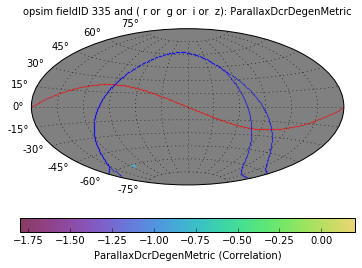

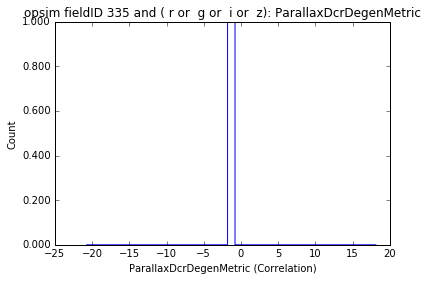

In [4]:
bgroup.plotAll(closefigs=False)

In [6]:
print 'Parallax-DCR amplitude correlation', bundleList[1].metricValues

 Parallax-DCR amplitude correlation [-0.7982174736706519]


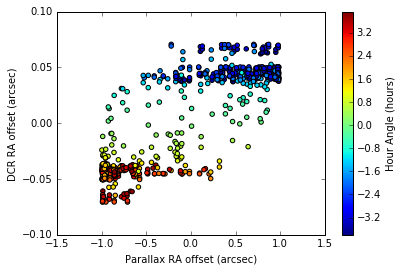

In [7]:
plt.scatter(bundle.metricValues[0]['ra_pi_amp'], bundle.metricValues[0]['ra_dcr_amp'], c=bundle.metricValues[0]['HA'])
plt.xlabel('Parallax RA offset (arcsec)')
plt.ylabel('DCR RA offset (arcsec)')
cb = plt.colorbar()
cb.set_label('Hour Angle (hours)')


This assumes a parallax of 1" and probably realistic values for the DCR. Moving the star farther away would contract the x-axis, but would not change the correlation between the parameters.


NOTE:  Green is at hour angle zero (crossing the meridian), and that is when the DCR would be completely in N-S (i.e., Dec) direction.  So, just shifting a fraction of the observations from -3 hours to the meridian would decrease the correlation and make things better.

But note, that for objects on the ecliptic, I don't think you can actually observe them at maximum parallax offset on the meridian (the sun would be at altitude 0).  So we need to think carefully about how to distribute observations near the ecliptic--some considerations:

* Some observations when stars are at max parallax factor
* Pairs of observations spaced ~1hr for moving SS objects
* Observations near opposition since SS things are brighter (?) (note this is parallax factor zero!)
* Avoid moon and bright planets
* Similar to the rest of the survey
* Possible to hunt for NEOs in twilight on ecliptic (?)

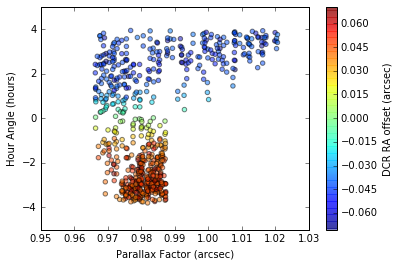

In [8]:
pi_r = (bundle.metricValues[0]['ra_pi_amp']**2 + bundle.metricValues[0]['dec_pi_amp']**2)**0.5

plt.scatter(pi_r, bundle.metricValues[0]['HA'], c=bundle.metricValues[0]['ra_dcr_amp'], alpha=.5)
plt.xlabel('Parallax Factor (arcsec)')
plt.ylabel('Hour Angle (hours)')
cb = plt.colorbar()
cb.set_label('DCR RA offset (arcsec)')


So, the problem with the previous metric is that it looked at just the parallax factor and couldn't catch situations where the DCR and parallax were degenerate in the RA or Dec direction.  

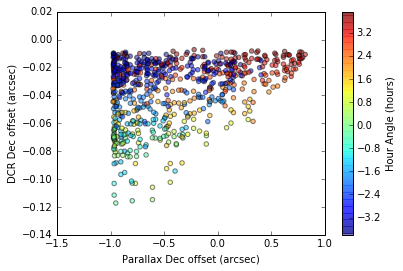

In [9]:
plt.scatter(bundle.metricValues[0]['dec_pi_amp'], bundle.metricValues[0]['dec_dcr_amp'], 
            c=bundle.metricValues[0]['HA'], alpha=.5)
plt.xlabel('Parallax Dec offset (arcsec)')
plt.ylabel('DCR Dec offset (arcsec)')
cb = plt.colorbar()
cb.set_label('Hour Angle (hours)')

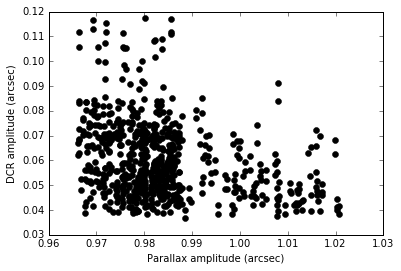

In [10]:
pi_r = (bundle.metricValues[0]['ra_pi_amp']**2 + bundle.metricValues[0]['dec_pi_amp']**2)**0.5
dcr_r = (bundle.metricValues[0]['ra_dcr_amp']**2 + bundle.metricValues[0]['dec_dcr_amp']**2)**0.5
plt.plot(pi_r, dcr_r, 'ko')
plt.xlabel('Parallax amplitude (arcsec)')
plt.ylabel('DCR amplitude (arcsec)')

Querying database with constraint fieldID = 836 and (filter = "r" or filter = "g" or filter = "i" or filter = "z")
Found 660 visits
Running:  ['opsim_Pass_fieldID_836_and_r_or_g_or_i_or_z_USER', 'opsim_ParallaxDcrDegenMetric_fieldID_836_and_r_or_g_or_i_or_z_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with fieldID = 836 and (filter = "r" or filter = "g" or filter = "i" or filter = "z") sqlconstraint now.
Plotting complete.
Parallax-DCR amplitude correlation [-0.45312623877715863]


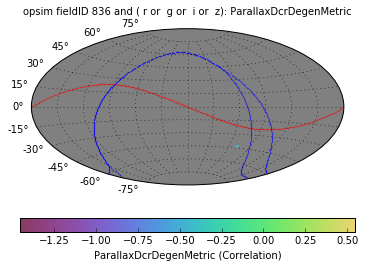

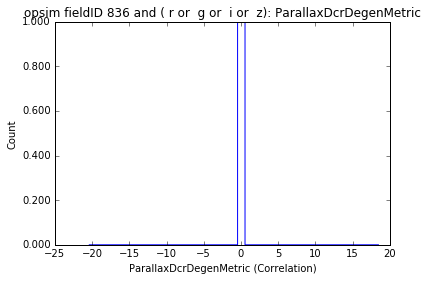

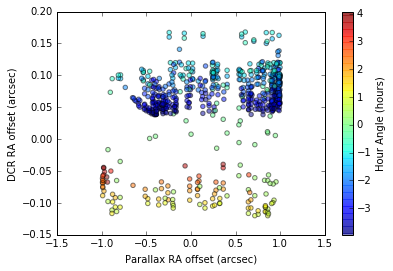

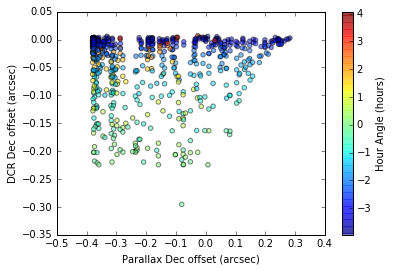

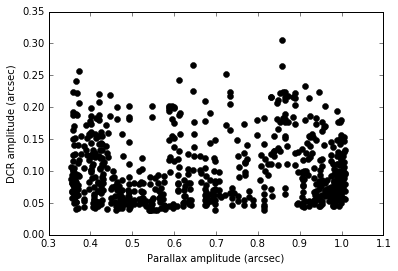

In [11]:
# And now for one that shouldn't look as bad
bundleList = []

slicer = slicers.UserPointsSlicer(5.060636, -0.746802)
metric = metrics.PassMetric()
sql = 'fieldID = 836 and (filter = "r" or filter = "g" or filter = "i" or filter = "z")'
stackerList = []
stackerList.append(stackers.ParallaxFactorStacker())
stackerList.append(stackers.DcrStacker())
bundle = metricBundles.MetricBundle(metric, slicer, sql, stackerList=stackerList)
bundleList.append(bundle)

bundleList.append(metricBundles.MetricBundle(metrics.ParallaxDcrDegenMetric(), slicer, sql, stackerList=stackerList))

bundleDict = metricBundles.makeBundlesDictFromList(bundleList)
bgroup = metricBundles.MetricBundleGroup(bundleDict, opsdb, outDir=outDir, resultsDb=resultsDb)
bgroup.runAll()
bgroup.plotAll(closefigs=False)
print 'Parallax-DCR amplitude correlation', bundleList[1].metricValues
plt.figure()
plt.scatter(bundle.metricValues[0]['ra_pi_amp'], bundle.metricValues[0]['ra_dcr_amp'], 
            c=bundle.metricValues[0]['HA'], alpha=0.5)
cb = plt.colorbar()
cb.set_label('Hour Angle (hours)')
plt.xlabel('Parallax RA offset (arcsec)')
plt.ylabel('DCR RA offset (arcsec)')
plt.figure()
plt.scatter(bundle.metricValues[0]['dec_pi_amp'], bundle.metricValues[0]['dec_dcr_amp'], 
            c=bundle.metricValues[0]['HA'], alpha=0.5)
cb = plt.colorbar()
cb.set_label('Hour Angle (hours)')
plt.xlabel('Parallax Dec offset (arcsec)')
plt.ylabel('DCR Dec offset (arcsec)')
plt.figure()
pi_r = (bundle.metricValues[0]['ra_pi_amp']**2 + bundle.metricValues[0]['dec_pi_amp']**2)**0.5
dcr_r = (bundle.metricValues[0]['ra_dcr_amp']**2 + bundle.metricValues[0]['dec_dcr_amp']**2)**0.5
plt.plot(pi_r, dcr_r, 'ko')
plt.xlabel('Parallax amplitude (arcsec)')
plt.ylabel('DCR amplitude (arcsec)')


Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Querying database with constraint filter = "r" or filter = "g" or filter = "i" or filter = "z"
Found 1820274 visits
Running:  ['opsim_ParallaxDcrDegenMetric_r_or_g_or_i_or_z_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with filter = "r" or filter = "g" or filter = "i" or filter = "z" sqlconstraint now.
monopole: -0.297483  dipole: lon: 113.222, lat: 76.3977, amp: 0.309522
Plotting complete.
number of healpix in danger zone= 13478


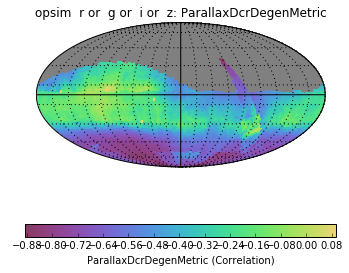

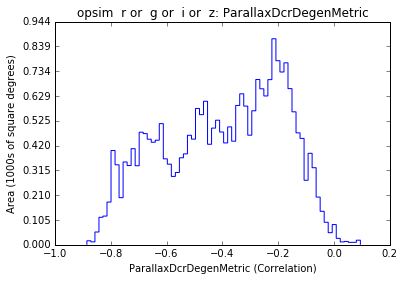

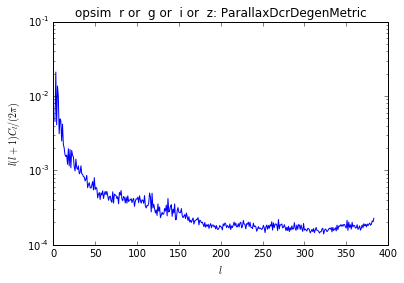

In [12]:
bundleList = []
slicer = slicers.HealpixSlicer()
sql = 'filter = "r" or filter = "g" or filter = "i" or filter = "z"'
bundleList.append(metricBundles.MetricBundle(metrics.ParallaxDcrDegenMetric(), slicer, sql, stackerList=stackerList))
bundleDict = metricBundles.makeBundlesDictFromList(bundleList)
bgroup = metricBundles.MetricBundleGroup(bundleDict, opsdb, outDir=outDir, resultsDb=resultsDb)
bgroup.runAll()
bgroup.plotAll(closefigs=False)
print 'number of healpix in danger zone=', np.where(np.abs(bundleList[0].metricValues) > 0.7)[0].size

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database with constraint filter = "r" or filter = "g" or filter = "i" or filter = "z"
Found 1820274 visits
Running:  ['opsim_Mean_HA_r_or_g_or_i_or_z_HEAL', 'opsim_Nvisits_as_function_of_Alt_Az_r_or_g_or_i_or_z_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with filter = "r" or filter = "g" or filter = "i" or filter = "z" sqlconstraint now.
Plotting complete.


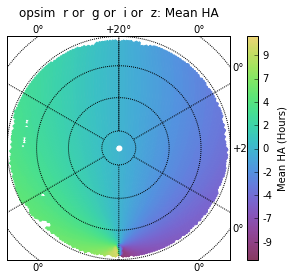

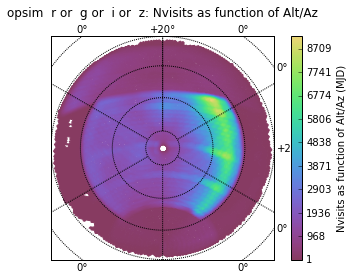

In [13]:
slicer = slicers.HealpixSlicer(nside=64, latCol='zenithDistance', lonCol='azimuth', useCache=False)
metric = metrics.CountMetric('expMJD', metricName='Nvisits as function of Alt/Az')
plotFuncs = [plots.LambertSkyMap()]
bundleList = []
bundleList.append(metricBundles.MetricBundle(metric, slicer, sql, plotFuncs=plotFuncs))
bundleList.append(metricBundles.MetricBundle(metrics.MeanMetric(col='HA'), slicer, sql, plotFuncs=plotFuncs))

bundleDict = metricBundles.makeBundlesDictFromList(bundleList)
bgroup = metricBundles.MetricBundleGroup(bundleDict, opsdb, outDir=outDir, resultsDb=resultsDb)
bgroup.runAll()
bgroup.plotAll(closefigs=False)

Querying database with constraint filter = "r" or filter = "g" or filter = "i" or filter = "z"
Found 1820274 visits
Running:  ['opsim_ParallaxDcrDegenMetric_r_or_g_or_i_or_z_OPSI']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with filter = "r" or filter = "g" or filter = "i" or filter = "z" sqlconstraint now.
Plotting complete.


/Users/yoachim/gitRepos/sims_maf/python/lsst/sims/maf/slicers/opsimFieldSlicer.py:65: UserWarning: Warning: this OpsimFieldSlicer was already set up once. Re-setting up an OpsimFieldSlicer can change the field information. Rerun metrics if this was intentional. 
  warnings.warn(warning_msg)


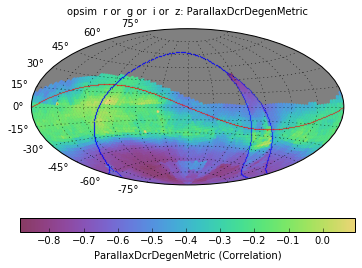

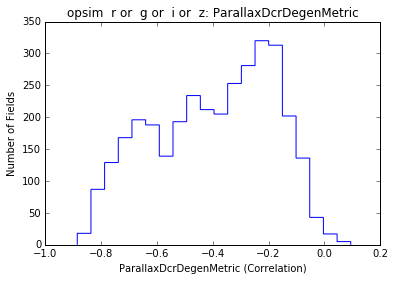

In [14]:
bundleList = []
slicer = slicers.OpsimFieldSlicer()
sql = 'filter = "r" or filter = "g" or filter = "i" or filter = "z"'
bundleList.append(metricBundles.MetricBundle(metrics.ParallaxDcrDegenMetric(), slicer, sql, stackerList=stackerList))
bundleDict = metricBundles.makeBundlesDictFromList(bundleList)
bgroup = metricBundles.MetricBundleGroup(bundleDict, opsdb, outDir=outDir, resultsDb=resultsDb)
bgroup.runAll()
bgroup.plotAll(closefigs=False)


In [21]:
print 'fieldID, metricValue'
for sid,val in zip(slicer.slicePoints['sid'], bundleList[0].metricValues):
    print sid, val

fieldID, metricValue
1 -0.631913591873
2 -0.747256406508
3 -0.634547312805
4 -0.660637439201
5 -0.715406090769
6 -0.745038706632
7 -0.731343863758
8 -0.745581506001
9 -0.701766072752
10 -0.797299857742
11 -0.781610911118
12 -0.716100863998
13 -0.730034386535
14 -0.741958248788
15 -0.768735485225
16 -0.783573403786
17 -0.731655245473
18 -0.703351143272
19 -0.833520111063
20 -0.822492043898
21 -0.670127362517
22 -0.680329726714
23 -0.72786719922
24 -0.758675085919
25 -0.78191327577
26 -0.751033059262
27 -0.661408990503
28 -0.713105037011
29 -0.691304813081
30 -0.815377417469
31 -0.807678519434
32 -0.709765766082
33 -0.730862673281
34 -0.728929660323
35 -0.773752296457
36 -0.834462582658
37 -0.815895977376
38 -0.84371764301
39 -0.665061156522
40 -0.68461711717
41 -0.715860395596
42 -0.639492753724
43 -0.705135977613
44 -0.786527900402
45 -0.661812169266
46 -0.696935798076
47 -0.686767221858
48 -0.770489022525
49 -0.791627933236
50 -0.711543238269
51 -0.674222935999
52 -0.66580495145
53 -0